In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from scipy.interpolate import griddata

In [3]:
from utils import grid_to_data
from approximation import adaptive_search

**Helper functions**

In [4]:
def load_fitted_contour(real_data_path):
	loglik_global = []
	loglik_profile = []
	with open(real_data_path, 'r') as f:
	    for line in f: 
	        loglik_global.append(float(line.split(',')[8][1:]))
	        loglik_profile.append(float(line.split(',')[9][1:-2]))
	loglik_global = np.asarray(loglik_global)
	loglik_profile = np.asarray(loglik_profile)
	contour_fit = np.zeros((20, 20))
	for i in range(400):
	    j = i / 20
	    k = i % 20
	    contour_fit[j, k] = 2 * (loglik_profile[i] - np.min(loglik_profile))
	return(contour_fit)

In [5]:
def grid_to_points(grid):
    points = np.zeros((20 * 20, 2))
    values = np.zeros(20 * 20)
    n = 0
    for i in range(20):
        for j in range(20):
            points[n, 0] = i * 1.0 / 20
            points[n, 1] = j * 1.0 / 20
            values[n] = grid[i, j]
            n += 1
    return(points, values)

In [6]:
def refine_grid(points, res):
    fine_grid = np.zeros((res * res, 2))
    n = 0
    for i in range(res):
        for j in range(res):
            fine_grid[n, 0] = i * np.max(points[:, 0]) / res
            fine_grid[n, 1] = j * np.max(points[:, 1]) / res
            n += 1
    return(fine_grid)

In [7]:
def smooth_grid(grid, res):
    points, values = grid_to_points(grid)
    fine_grid = refine_grid(points, res)
    return(griddata(points, values, fine_grid, method='linear').reshape((res, res)))

**Load data**

In [8]:
contour_thres = np.load('/Users/linggeli/monte_carlo/penalty_contour_68.npy')
print(contour_thres.shape)

(20, 20)


In [9]:
contour_stat = load_fitted_contour('/Users/linggeli/Downloads/penalty_inverted/contour_inverted_fit_60.txt')
print(contour_stat.shape)

(20, 20)


**Smooth the data before analysis (testing)** 

In [10]:
smooth_flag = False
grid_size = 40

In [11]:
if smooth_flag:
    contour_thres = smooth_grid(contour_thres, grid_size)
    contour_stat = smooth_grid(contour_stat, grid_size)
    print(contour_thres.shape)
    print(contour_thres.shape)

**Visualize the data**

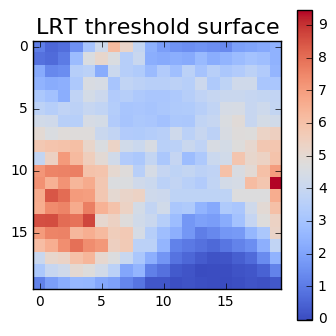

In [12]:
fig = plt.figure(figsize=(4, 4))
im = plt.imshow(contour_thres, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im)
plt.title('LRT threshold surface', fontsize=16)
plt.show()

In [13]:
#contour_stat[contour_stat > np.max(contour_thres)] = np.max(contour_thres) + 1.0

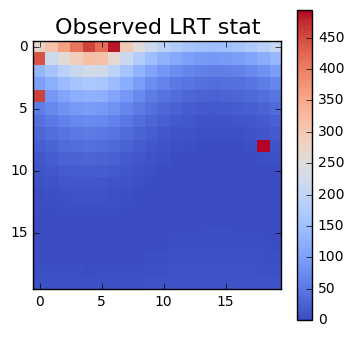

In [14]:
fig = plt.figure(figsize=(4, 4))
im = plt.imshow(contour_stat, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im)
plt.title('Observed LRT stat', fontsize=16)
plt.show()

In [15]:
contour_true = contour_stat < contour_thres

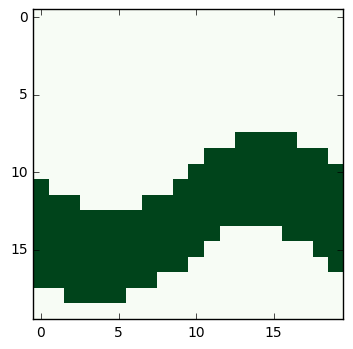

In [16]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(contour_true, cmap='Greens', interpolation='nearest')
plt.show()

**Pre-process the data**

In [17]:
data = grid_to_data(contour_thres)
all_points = data[:, 0:2]
target = data[:, 2]
lr_stats = grid_to_data(contour_stat)[:, 2]
print(all_points.shape)
print(target.shape)
print(lr_stats.shape)

(400, 2)
(400,)
(400,)


RBF(length_scale=0.365) + WhiteKernel(noise_level=1.34)


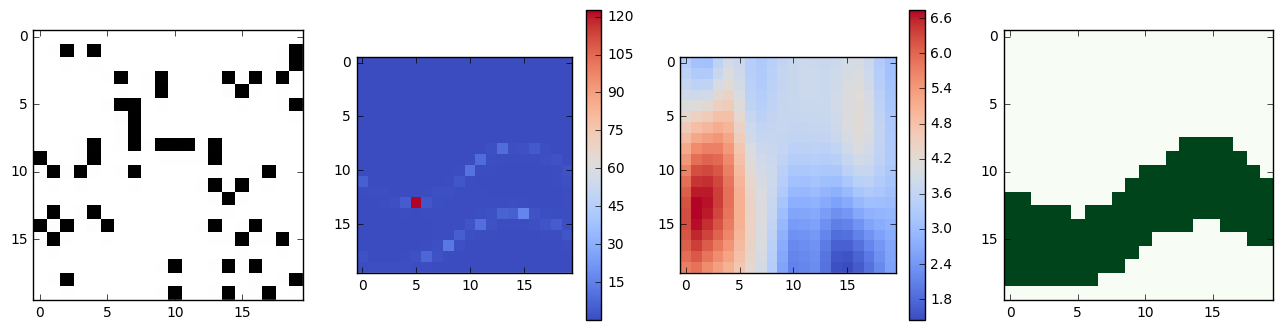

RBF(length_scale=0.336) + WhiteKernel(noise_level=0.963)


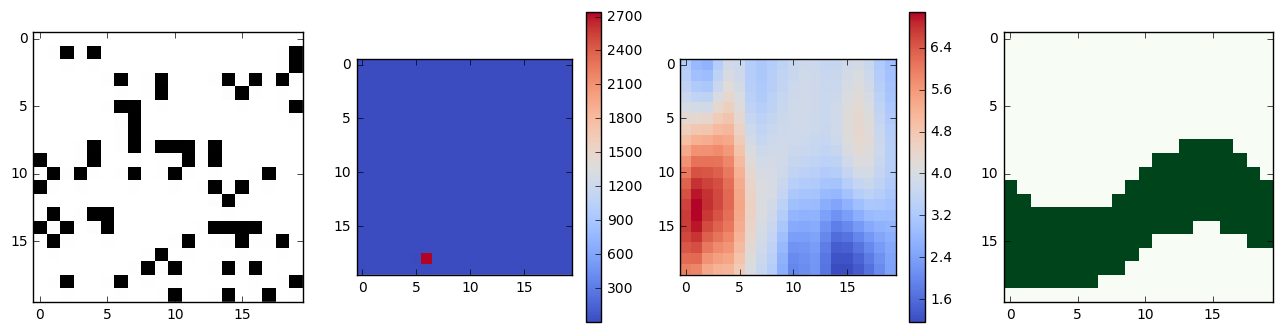

RBF(length_scale=0.29) + WhiteKernel(noise_level=0.786)


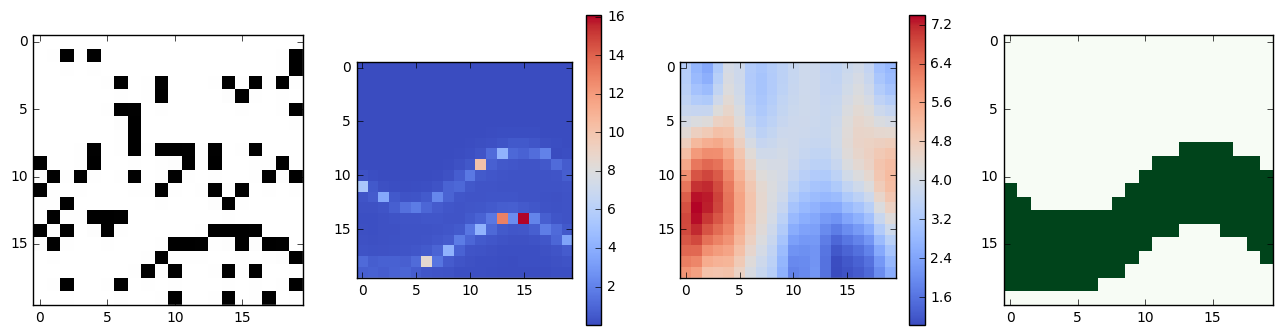

RBF(length_scale=0.266) + WhiteKernel(noise_level=0.826)


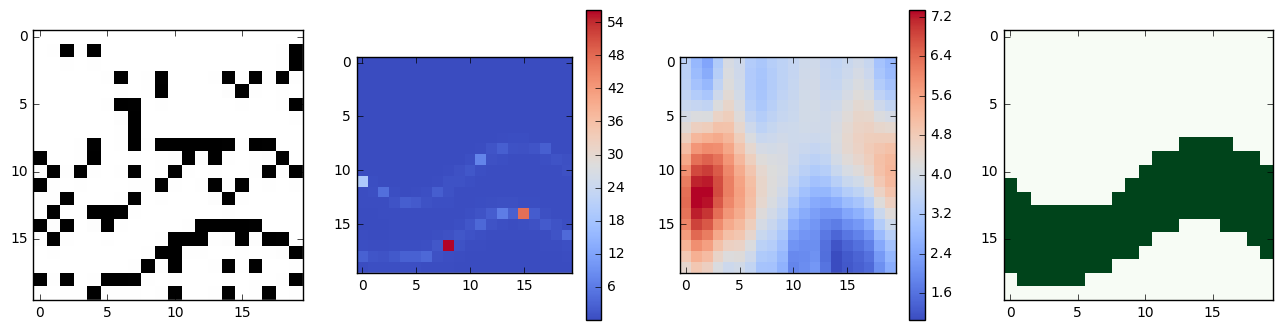

RBF(length_scale=0.26) + WhiteKernel(noise_level=0.679)


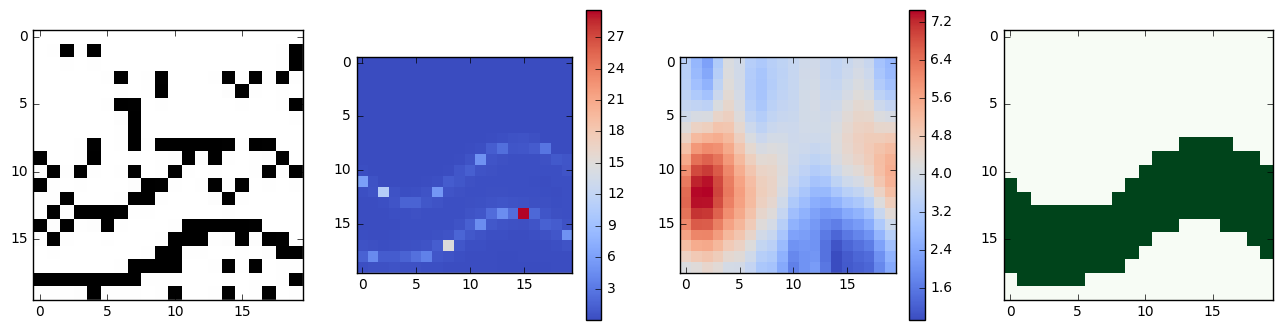

RBF(length_scale=0.251) + WhiteKernel(noise_level=0.525)


In [18]:
contour_thres_hat, contour_hat = adaptive_search(all_points, target, lr_stats, 50, 5, 10, verbose=True)

**Compare and calculate differences**

In [19]:
contour_diff = contour_hat != contour_true
print(contour_diff.shape)

(20, 20)


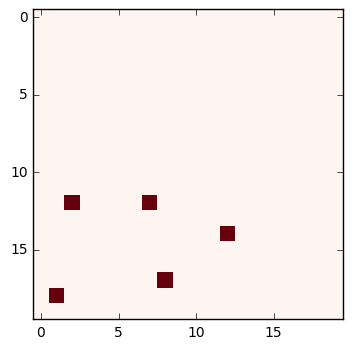

In [20]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(contour_diff, cmap='Reds', interpolation='nearest')
plt.show()

In [21]:
print(1 - np.mean(contour_diff))

0.9875


**Post hoc smoothing of confidence region**

In [22]:
contour_true_smooth = smooth_grid(contour_true, 40) > 0.5
contour_hat_smooth = smooth_grid(contour_hat, 40) > 0.5

In [23]:
contour_diff = contour_hat_smooth != contour_true_smooth

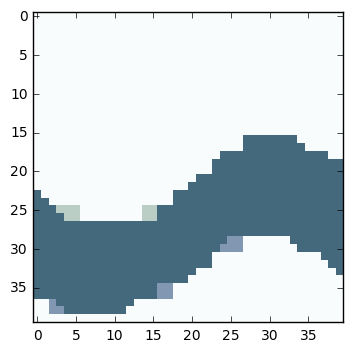

In [24]:
fig = plt.figure(figsize=(4, 4))
plt.imshow(contour_true_smooth, cmap='Greens', interpolation='nearest', alpha=0.5)
plt.imshow(contour_hat_smooth, cmap='Blues', interpolation='nearest', alpha=0.5)
plt.show()

In [25]:
print(1 - np.mean(contour_diff))

0.986875


**Put everything in a function**

In [26]:
def perform_comparison(real_data_num, post_hoc_smooth=True, verbose=True):
    contour_thres = np.load('/Users/linggeli/monte_carlo/penalty_contour_68.npy')
    contour_stat = load_fitted_contour('/Users/linggeli/Downloads/penalty_inverted/contour_inverted_fit_{}.txt'.format(real_data_num))
    contour_true = contour_stat < contour_thres
    data = grid_to_data(contour_thres)
    all_points = data[:, 0:2]
    target = data[:, 2]
    lr_stats = grid_to_data(contour_stat)[:, 2]
    contour_thres_hat, contour_hat = adaptive_search(all_points, target, lr_stats, 50, 5, 10, verbose=False)
    if post_hoc_smooth:
        contour_true = smooth_grid(contour_true, 40) > 0.5
        contour_hat = smooth_grid(contour_hat, 40) > 0.5
    contour_diff = contour_hat != contour_true
    if verbose:
        fig = plt.figure(figsize=(4, 4))
        plt.imshow(contour_true, cmap='Greens', interpolation='nearest', alpha=0.5)
        plt.imshow(contour_hat, cmap='Blues', interpolation='nearest', alpha=0.5)
        plt.show()
    overlap = 1 - np.mean(contour_diff)
    print('Percentage of pointwise overlap: {}'.format(overlap))
    return(overlap)

RBF(length_scale=0.219) + WhiteKernel(noise_level=1.38)
RBF(length_scale=0.225) + WhiteKernel(noise_level=1.41)
RBF(length_scale=0.235) + WhiteKernel(noise_level=1.16)
RBF(length_scale=0.247) + WhiteKernel(noise_level=0.924)
RBF(length_scale=0.25) + WhiteKernel(noise_level=0.607)
RBF(length_scale=0.248) + WhiteKernel(noise_level=0.451)


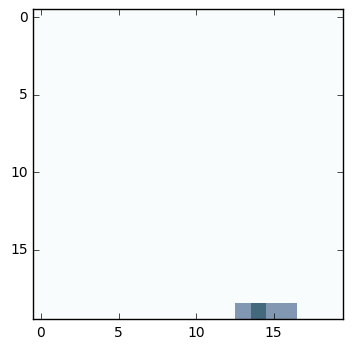

Percentage of pointwise overlap: 0.9925


In [27]:
result = perform_comparison(50, post_hoc_smooth=False)

In [28]:
results = []
for i in range(200):
    result = perform_comparison(i, post_hoc_smooth=True, verbose=False)
    results.append(result)

RBF(length_scale=0.252) + WhiteKernel(noise_level=1.23)
RBF(length_scale=0.256) + WhiteKernel(noise_level=0.677)
RBF(length_scale=0.259) + WhiteKernel(noise_level=0.406)
RBF(length_scale=0.225) + WhiteKernel(noise_level=0.0621)
RBF(length_scale=0.214) + WhiteKernel(noise_level=0.0386)
RBF(length_scale=0.268) + WhiteKernel(noise_level=0.372)
Percentage of pointwise overlap: 0.995
RBF(length_scale=0.249) + WhiteKernel(noise_level=0.57)
RBF(length_scale=0.263) + WhiteKernel(noise_level=0.899)
RBF(length_scale=0.292) + WhiteKernel(noise_level=0.892)
RBF(length_scale=0.308) + WhiteKernel(noise_level=0.68)
RBF(length_scale=0.312) + WhiteKernel(noise_level=0.626)
RBF(length_scale=0.308) + WhiteKernel(noise_level=0.484)
Percentage of pointwise overlap: 0.995625
RBF(length_scale=0.367) + WhiteKernel(noise_level=0.454)
RBF(length_scale=0.369) + WhiteKernel(noise_level=0.439)
RBF(length_scale=0.378) + WhiteKernel(noise_level=0.604)
RBF(length_scale=0.358) + WhiteKernel(noise_level=0.647)
RBF(leng

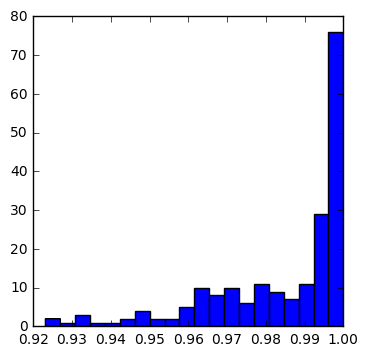

In [29]:
results = np.asarray(results)
fig = plt.figure(figsize=(4, 4))
plt.hist(results, bins=20)
plt.show()

In [31]:
print(np.mean(results))
print(np.median(results))
print(np.std(results))

0.984259375
0.994375
0.018153003959
